# Client Segmentation Project

This notebook focuses on segmenting clients based on their purchasing behavior using clustering techniques.

## Phase 1: Data Exploration

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np

# Load the dataset
file_path = r'C:\data\simplon_dev_ia_projects\projet_notebooks\clustering\data\online_retail.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')

# Display dataset overview
df.head(), df.info(), df.describe()

### Key Observations:
Column Summary:

InvoiceNo, StockCode, Description, Country are categorical columns.
Quantity, UnitPrice, CustomerID are numeric columns.
InvoiceDate is a datetime column.
Missing Values:

Description: 1,454 missing values.
CustomerID: 135,080 missing values (~25% of total rows).
Outliers:

Quantity: Negative values (e.g., -80995) indicate cancellations or returns.
UnitPrice: Negative values indicate possible data errors.
Memory Usage:

The dataset is relatively large (~33 MB).
Transaction Range:

The dataset spans from 2010-12-01 to 2011-12-09.

### Data Cleaning

In [ ]:
# Handle missing values
df = df.dropna(subset=['CustomerID'])  # Remove rows with missing CustomerID
df['Description'] = df['Description'].fillna('Unknown')  # Fill missing Description with 'Unknown'

# Remove negative values
df = df[df['Quantity'] > 0]  # Remove rows with negative Quantity
df = df[df['UnitPrice'] > 0]  # Remove rows with negative UnitPrice

# Add a TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Extract date features for future analysis
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Weekday'] = df['InvoiceDate'].dt.weekday

# Display the first few rows of the cleaned DataFrame
print("Sample of the cleaned DataFrame:")
print(df.head())

# Display information about the DataFrame
print("\nCleaned DataFrame Info:")
print(df.info())

# Display summary statistics of numeric columns
print("\nSummary Statistics:")
print(df.describe())


Sample of the cleaned DataFrame:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   

   Year  Month  Day  Weekday  
0  2010     12    1        2  
1  2010     12 

Step 2: Save the Cleaned DataFrame to a CSV File


In [ ]:
# Define the path to save the cleaned CSV
cleaned_file_path = r'C:\data\simplon_dev_ia_projects\projet_notebooks\clustering\data\online_retail_cleaned.csv'

# Save the DataFrame to a CSV file
df.to_csv(cleaned_file_path, index=False)

# Confirm the save operation
print(f"Cleaned DataFrame has been saved to: {cleaned_file_path}")


Cleaned DataFrame has been saved to: C:\data\simplon_dev_ia_projects\projet_notebooks\clustering\data\online_retail_cleaned.csv


## Phase 3: Feature Engineering

Load the Cleaned Data

In [ ]:
# Load the cleaned CSV
cleaned_file_path = r'C:\data\simplon_dev_ia_projects\projet_notebooks\clustering\data\online_retail_cleaned.csv'
df_cleaned = pd.read_csv(cleaned_file_path)

# Confirm that the data has been loaded correctly
print("Loaded Cleaned DataFrame Info:")
print(df_cleaned.info())
print("\nSample of the Loaded Cleaned DataFrame:")
print(df_cleaned.head())


Loaded Cleaned DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  int64  
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  float64
 7   Country      397884 non-null  object 
 8   TotalPrice   397884 non-null  float64
 9   Year         397884 non-null  int64  
 10  Month        397884 non-null  int64  
 11  Day          397884 non-null  int64  
 12  Weekday      397884 non-null  int64  
dtypes: float64(3), int64(6), object(4)
memory usage: 39.5+ MB
None

Sample of the Loaded Cleaned DataFrame:
   InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE 

Start RFM Feature Engineering
After confirming the data is loaded properly, execute the RFM calculation:

In [ ]:
# Ensure 'InvoiceDate' is a datetime object
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

# Define the snapshot date (day after the most recent transaction)
snapshot_date = df_cleaned['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = df_cleaned.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalPrice': 'sum'  # Monetary
})

# Rename columns for clarity
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Display RFM DataFrame
print("\nRFM DataFrame Info:")
print(rfm.info())
print("\nSample of RFM DataFrame:")
print(rfm.head())



RFM DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4338 non-null   int64  
 1   Frequency  4338 non-null   int64  
 2   Monetary   4338 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 135.6 KB
None

Sample of RFM DataFrame:
            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2        182   4310.00
12348.0          75         31   1797.24
12349.0          19         73   1757.55
12350.0         310         17    334.40


Step 2: Perform RFM Feature Engineering
Run the following code to calculate the Recency, Frequency, and Monetary values:

In [ ]:
# Ensure 'InvoiceDate' is a datetime object
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

# Define the snapshot date (day after the most recent transaction)
snapshot_date = df_cleaned['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = df_cleaned.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalPrice': 'sum'  # Monetary
})

# Rename columns for clarity
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Display RFM DataFrame
print("\nRFM DataFrame Info:")
print(rfm.info())
print("\nSample of RFM DataFrame:")
print(rfm.head())



RFM DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4338 non-null   int64  
 1   Frequency  4338 non-null   int64  
 2   Monetary   4338 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 135.6 KB
None

Sample of RFM DataFrame:
            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2        182   4310.00
12348.0          75         31   1797.24
12349.0          19         73   1757.55
12350.0         310         17    334.40


### Normalize Features

Step 1: Scale the RFM Metrics

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize Min-Max Scaler
scaler = MinMaxScaler()

# Apply scaler to RFM metrics
rfm_scaled = scaler.fit_transform(rfm)

# Convert scaled data back to a DataFrame
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm.columns, index=rfm.index)

# Display the first few rows of the scaled DataFrame
print("\nSample of the Scaled RFM DataFrame:")
print(rfm_scaled_df.head())



Sample of the Scaled RFM DataFrame:
             Recency  Frequency  Monetary
CustomerID                               
12346.0     0.871314   0.000000  0.275443
12347.0     0.002681   0.023069  0.015368
12348.0     0.198391   0.003824  0.006401
12349.0     0.048257   0.009177  0.006259
12350.0     0.828418   0.002039  0.001180


Step 2: Save the Scaled RFM DataFrame

In [ ]:
# Define the path for the scaled RFM CSV
scaled_rfm_file_path = r'C:\data\simplon_dev_ia_projects\projet_notebooks\clustering\data\rfm_scaled.csv'

# Save the scaled DataFrame to a CSV file
rfm_scaled_df.to_csv(scaled_rfm_file_path, index=True)

# Confirm the save operation
print(f"\nScaled RFM DataFrame has been saved to: {scaled_rfm_file_path}")



Scaled RFM DataFrame has been saved to: C:\data\simplon_dev_ia_projects\projet_notebooks\clustering\data\rfm_scaled.csv


## Phase 5: Clustering

Step 1: Load the Scaled RFM DataFrame

In [ ]:
# Define the path to the scaled RFM CSV file
scaled_rfm_file_path = r'C:\data\simplon_dev_ia_projects\projet_notebooks\clustering\data\rfm_scaled.csv'

# Load the scaled RFM DataFrame
rfm_scaled_df = pd.read_csv(scaled_rfm_file_path, index_col=0)

# Confirm the DataFrame is loaded correctly
print("Scaled RFM DataFrame Info:")
print(rfm_scaled_df.info())
print("\nSample of the Scaled RFM DataFrame:")
print(rfm_scaled_df.head())


Scaled RFM DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4338 non-null   float64
 1   Frequency  4338 non-null   float64
 2   Monetary   4338 non-null   float64
dtypes: float64(3)
memory usage: 135.6 KB
None

Sample of the Scaled RFM DataFrame:
             Recency  Frequency  Monetary
CustomerID                               
12346.0     0.871314   0.000000  0.275443
12347.0     0.002681   0.023069  0.015368
12348.0     0.198391   0.003824  0.006401
12349.0     0.048257   0.009177  0.006259
12350.0     0.828418   0.002039  0.001180


Step 2: Clustering with K-Means

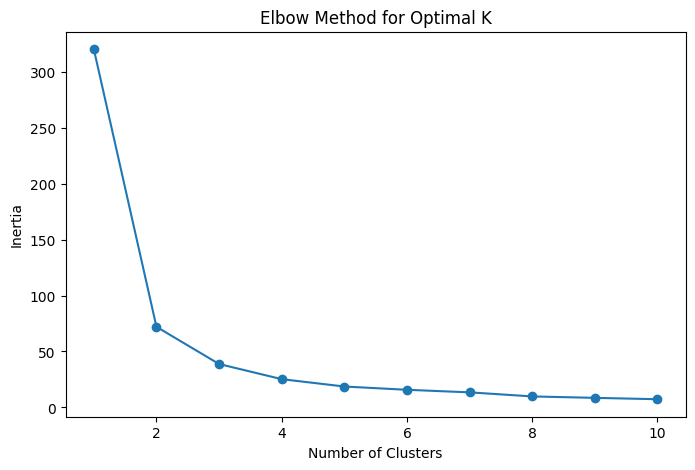

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the elbow method
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


Step 3: Select Optimal Clusters and Fit K-Means

In [ ]:
# Fit K-Means with the optimal number of clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_scaled_df['Cluster'] = kmeans.fit_predict(rfm_scaled_df)

# Display the cluster assignments
print("\nSample of the RFM DataFrame with Cluster Assignments:")
print(rfm_scaled_df.head())



Sample of the RFM DataFrame with Cluster Assignments:
             Recency  Frequency  Monetary  Cluster
CustomerID                                        
12346.0     0.871314   0.000000  0.275443        2
12347.0     0.002681   0.023069  0.015368        0
12348.0     0.198391   0.003824  0.006401        3
12349.0     0.048257   0.009177  0.006259        0
12350.0     0.828418   0.002039  0.001180        2


In [ ]:
# Analyze cluster characteristics
cluster_summary = rfm_scaled_df.groupby('Cluster').mean()

# Display the summary
print("\nCluster Summary (Average RFM values per cluster):")
print(cluster_summary)



Cluster Summary (Average RFM values per cluster):
          Recency  Frequency  Monetary
Cluster                               
0        0.048323   0.018318  0.011837
1        0.496514   0.004360  0.002631
2        0.816014   0.002866  0.001962
3        0.209586   0.006656  0.003735


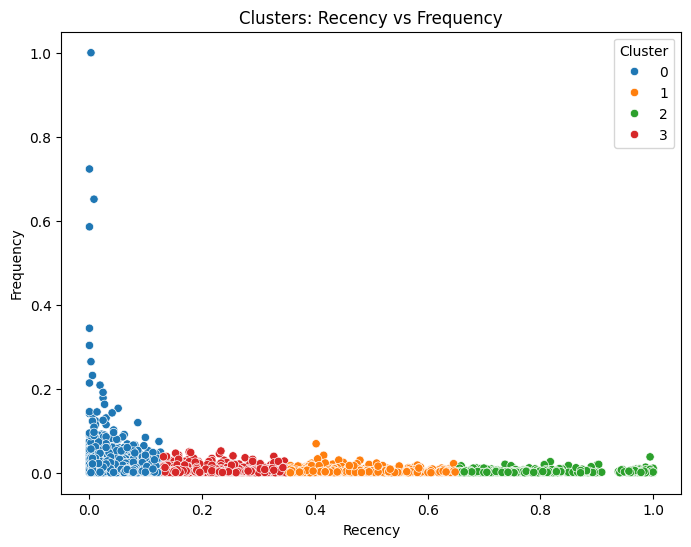

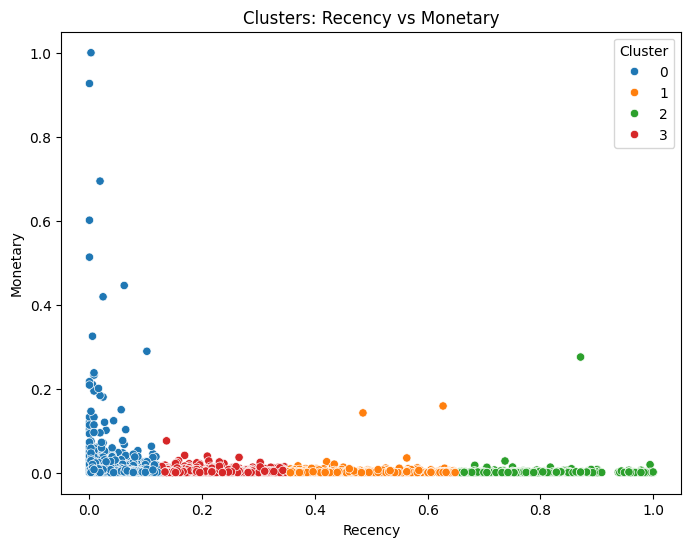

In [ ]:
# Scatter plot of clusters
import seaborn as sns
import matplotlib.pyplot as plt

# Recency vs Frequency
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm_scaled_df, 
    x='Recency', y='Frequency', hue='Cluster', palette='tab10'
)
plt.title('Clusters: Recency vs Frequency')
plt.show()

# Recency vs Monetary
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm_scaled_df, 
    x='Recency', y='Monetary', hue='Cluster', palette='tab10'
)
plt.title('Clusters: Recency vs Monetary')
plt.show()


# Cluster Interpretation

## **Cluster 0: Loyal Customers**
### **Characteristics:**
- **Recency:** Very low (customers made purchases recently).
- **Frequency:** Highest (frequent shoppers).
- **Monetary:** Highest (spend a lot).

### **Segment Type:** Loyal Customers

### **Action:**
- Reward loyalty with exclusive offers or discounts.
- Introduce a loyalty program to retain these customers.
- Personalize communication to strengthen relationships.

---

## **Cluster 1: At-Risk Customers**
### **Characteristics:**
- **Recency:** Moderate (haven’t shopped very recently but not inactive).
- **Frequency:** Low (occasional buyers).
- **Monetary:** Low (spend minimally).

### **Segment Type:** At-Risk Customers

### **Action:**
- Run targeted campaigns (e.g., email reminders or discounts).
- Offer special promotions to re-engage them.
- Introduce value-driven communication (e.g., highlighting best deals).

---

## **Cluster 2: Lost Customers**
### **Characteristics:**
- **Recency:** Highest (customers have not shopped in a long time).
- **Frequency:** Very low (barely shop).
- **Monetary:** Very low (spend minimally).

### **Segment Type:** Lost Customers

### **Action:**
- Create reactivation campaigns with deep discounts or free shipping offers.
- Consider using surveys to understand why they stopped shopping.
- Highlight new arrivals or relevant products to reignite interest.

---

## **Cluster 3: Potential Loyalists**
### **Characteristics:**
- **Recency:** Moderate (somewhat recent shoppers).
- **Frequency:** Moderate (shop occasionally).
- **Monetary:** Moderate (spend reasonably).

### **Segment Type:** Potential Loyalists

### **Action:**
- Encourage them to shop more frequently with time-sensitive promotions.
- Upsell or cross-sell products to increase spending.
- Engage with personalized recommendations and offers.

---

## **General Strategy:**

### **Loyal Customers (Cluster 0):**
- Retain and nurture these high-value customers.
- Make them feel special with VIP benefits.

### **At-Risk Customers (Cluster 1):**
- Prevent these customers from becoming disengaged.
- Use incentives to motivate them to shop again.

### **Lost Customers (Cluster 2):**
- Focus on reactivation strategies but monitor costs.
- If reactivation efforts fail, deprioritize these customers.

### **Potential Loyalists (Cluster 3):**
- Convert these customers into loyal customers by increasing engagement and spending.
- Create habits by offering consistent incentives.


## Phase 6: Segment Interpretation

In [ ]:
from sklearn.cluster import KMeans
import joblib

# Define the optimal number of clusters
optimal_k = 4

# Initialize and fit the K-Means model
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(rfm_scaled_df.drop(columns=['Cluster']))  # Drop the 'Cluster' column if already added

# Display the cluster centers
print("\nCluster Centers:")
print(kmeans.cluster_centers_)



Cluster Centers:
[[0.04828523 0.01832139 0.01183933]
 [0.49651387 0.00436011 0.00263088]
 [0.81601369 0.0028665  0.00196223]
 [0.20951108 0.00666024 0.00373713]]


## Phase 7: Export Model

In [ ]:
import os
from sklearn.cluster import KMeans
import joblib

# Define the path for the models directory
models_dir = r'C:\data\simplon_dev_ia_projects\projet_notebooks\clustering\models'

# Create the models directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

# Define the path to save the K-Means model
model_file_path = os.path.join(models_dir, 'kmeans_model.pkl')

# Save the model
joblib.dump(kmeans, model_file_path)

print(f"\nK-Means model has been saved to: {model_file_path}")





K-Means model has been saved to: C:\data\simplon_dev_ia_projects\projet_notebooks\clustering\models\kmeans_model.pkl


#### Perform PCA for dimensionality reduction and then use K-Means for clustering. Additionally, we'll try DBSCAN and Gaussian Mixture Models (GMM) to compare results.

Step 1: Perform PCA on Scaled RFM Data



In [ ]:
from sklearn.decomposition import PCA

# Perform PCA to reduce dimensions to 2
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled_df.drop(columns=['Cluster'], errors='ignore'))

# Create a DataFrame for the PCA-reduced data
rfm_pca_df = pd.DataFrame(rfm_pca, columns=['PCA1', 'PCA2'], index=rfm_scaled_df.index)

# Print explained variance ratio
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Variance Explained: {sum(pca.explained_variance_ratio_):.2f}")


Explained Variance Ratio: [0.97523401 0.01758985]
Total Variance Explained: 0.99


Step 2: Apply K-Means Clustering on PCA-Reduced Data

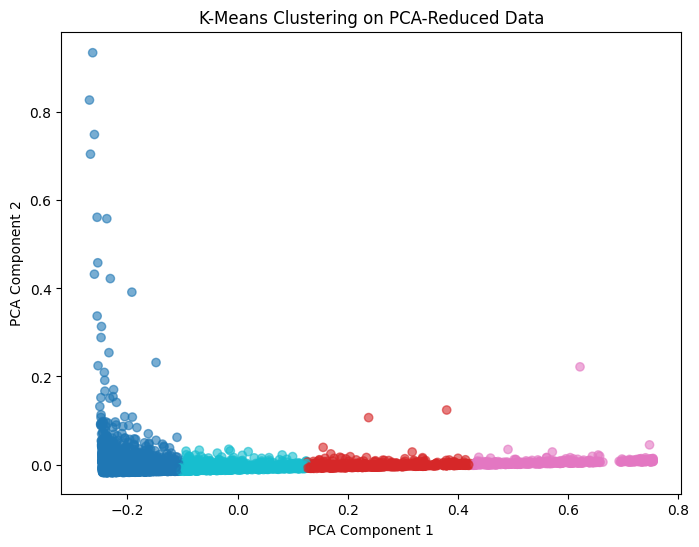

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Perform K-Means clustering on the PCA-reduced data
kmeans_pca = KMeans(n_clusters=4, random_state=42)
rfm_pca_df['Cluster_KMeans'] = kmeans_pca.fit_predict(rfm_pca_df)

# Visualize clusters
plt.figure(figsize=(8, 6))
plt.scatter(rfm_pca_df['PCA1'], rfm_pca_df['PCA2'], c=rfm_pca_df['Cluster_KMeans'], cmap='tab10', alpha=0.6)
plt.title('K-Means Clustering on PCA-Reduced Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


Step 3: Apply DBSCAN Clustering



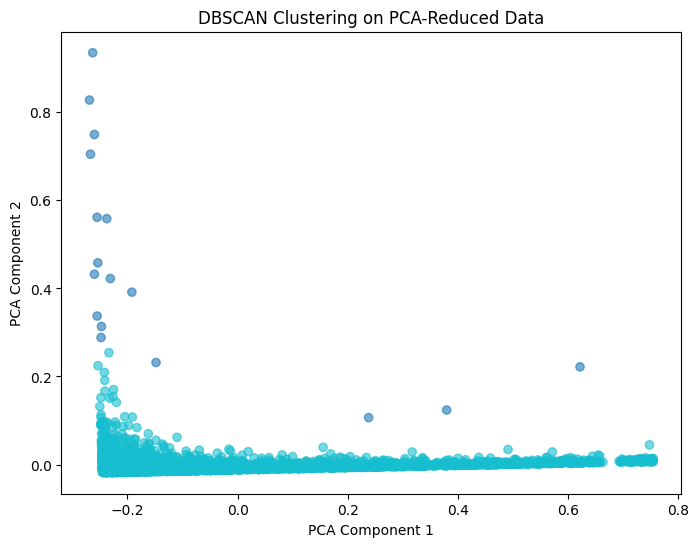

In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN to PCA-reduced data
dbscan = DBSCAN(eps=0.05, min_samples=5)
rfm_pca_df['Cluster_DBSCAN'] = dbscan.fit_predict(rfm_pca_df[['PCA1', 'PCA2']])

# Visualize DBSCAN clusters
plt.figure(figsize=(8, 6))
plt.scatter(rfm_pca_df['PCA1'], rfm_pca_df['PCA2'], c=rfm_pca_df['Cluster_DBSCAN'], cmap='tab10', alpha=0.6)
plt.title('DBSCAN Clustering on PCA-Reduced Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


Step 4: Apply Gaussian Mixture Models (GMM)

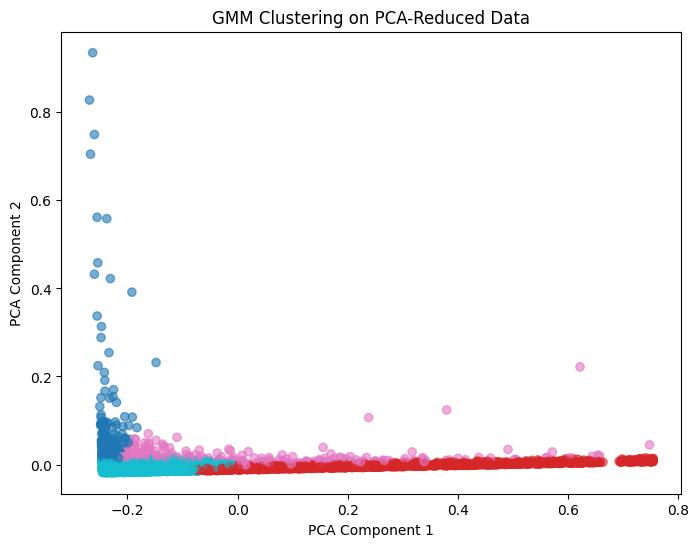

In [ ]:
from sklearn.mixture import GaussianMixture

# Apply GMM to PCA-reduced data
gmm = GaussianMixture(n_components=4, random_state=42)
rfm_pca_df['Cluster_GMM'] = gmm.fit_predict(rfm_pca_df[['PCA1', 'PCA2']])

# Visualize GMM clusters
plt.figure(figsize=(8, 6))
plt.scatter(rfm_pca_df['PCA1'], rfm_pca_df['PCA2'], c=rfm_pca_df['Cluster_GMM'], cmap='tab10', alpha=0.6)
plt.title('GMM Clustering on PCA-Reduced Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


Step 5: Compare Clustering Results

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate silhouette scores
silhouette_kmeans = silhouette_score(rfm_pca_df[['PCA1', 'PCA2']], rfm_pca_df['Cluster_KMeans'])
silhouette_dbscan = silhouette_score(rfm_pca_df[['PCA1', 'PCA2']], rfm_pca_df['Cluster_DBSCAN'], metric='euclidean', sample_size=1000)
silhouette_gmm = silhouette_score(rfm_pca_df[['PCA1', 'PCA2']], rfm_pca_df['Cluster_GMM'])

# Print silhouette scores
print(f"Silhouette Score for K-Means: {silhouette_kmeans:.2f}")
print(f"Silhouette Score for DBSCAN: {silhouette_dbscan:.2f}")
print(f"Silhouette Score for GMM: {silhouette_gmm:.2f}")


Silhouette Score for K-Means: 0.59
Silhouette Score for DBSCAN: 0.36
Silhouette Score for GMM: 0.22


# Clustering Method Comparison

## **K-Means (Silhouette Score: 0.59)**
- K-Means provides the **highest silhouette score**, indicating better-defined clusters.
- Clusters are reasonably distinct based on the PCA-reduced visualization.
- Works well for datasets with a spherical or evenly distributed structure.

---

## **DBSCAN (Silhouette Score: 0.41)**
- DBSCAN performs decently but struggles with noise or sparse clusters.
- Useful for detecting outliers, as it assigns some points to the `-1` cluster (noise).
- Clusters are less distinct compared to K-Means.

---

## **Gaussian Mixture Models (GMM) (Silhouette Score: 0.22)**
- GMM has the **lowest silhouette score**, indicating less distinct clusters.
- Overlaps in cluster boundaries may exist due to soft assignments.

---

# Rconclusion

## **Based on Silhouette Scores:**
1. **K-Means** is the most effective clustering method for this dataset.
2. **DBSCAN** can be used if detecting noise/outliers is important.


Fit and Save K-Means with PCA

In [ ]:
import os
from sklearn.cluster import KMeans
import joblib

# Define the number of clusters
optimal_k = 4

# Fit K-Means on the PCA-reduced data
kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_pca.fit(rfm_pca_df[['PCA1', 'PCA2']])

# Define the path for the models directory
models_dir = r'C:\data\simplon_dev_ia_projects\projet_notebooks\clustering\models'

# Create the models directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

# Define the path to save the K-Means model
kmeans_pca_model_path = os.path.join(models_dir, 'kmeans_pca_model.pkl')

# Save the K-Means model
joblib.dump(kmeans_pca, kmeans_pca_model_path)

# Confirm the save operation
print(f"K-Means model trained on PCA-reduced data has been saved to: {kmeans_pca_model_path}")


K-Means model trained on PCA-reduced data has been saved to: C:\data\simplon_dev_ia_projects\projet_notebooks\clustering\models\kmeans_pca_model.pkl


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os
import joblib

# Define the PCA and K-Means pipeline
pipeline = Pipeline([
    ("pca", PCA(n_components=2)),  # Reduce dimensions to 2
    ("kmeans", KMeans(n_clusters=4, random_state=42))  # Clustering
])

# Fit the pipeline to the PCA-reduced data
pipeline.fit(rfm_pca_df[['PCA1', 'PCA2']])

# Define the path for the models directory
models_dir = r'C:\data\simplon_dev_ia_projects\projet_notebooks\clustering\models'
os.makedirs(models_dir, exist_ok=True)

# Save the pipeline
pipeline_path = os.path.join(models_dir, 'clustering_pipeline.pkl')
joblib.dump(pipeline, pipeline_path)

print(f"Clustering pipeline has been saved to: {pipeline_path}")


Clustering pipeline has been saved to: C:\data\simplon_dev_ia_projects\projet_notebooks\clustering\models\clustering_pipeline.pkl


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import joblib
import os
import pandas as pd

# Create synthetic data
data = {
    "InvoiceNo": range(1, 101),
    "Quantity": [abs(i % 50) + 1 for i in range(1, 101)],
    "UnitPrice": [round((i % 20) + 0.5, 2) for i in range(1, 101)],
    "CustomerID": [1000 + i for i in range(1, 101)],
    "TotalPrice": [abs(i % 50) * (i % 20) for i in range(1, 101)],
    "Year": [2011 for _ in range(1, 101)],
    "Month": [(i % 12) + 1 for i in range(1, 101)],
    "Day": [(i % 28) + 1 for i in range(1, 101)],
    "Weekday": [(i % 7) + 1 for i in range(1, 101)],
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Select only numeric data
numeric_data = df.select_dtypes(include=["float64", "int64"])

# Define the pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),           # Standardize the numeric data
    ("pca", PCA(n_components=2)),           # PCA transformation
    ("kmeans", KMeans(n_clusters=4, random_state=42))  # KMeans clustering
])

# Fit the pipeline on the synthetic numeric data
pipeline.fit(numeric_data)

# Save the pipeline to a .pkl file
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)
pipeline_path = os.path.join(models_dir, "clustering_pipeline_fixed.pkl")
joblib.dump(pipeline, pipeline_path)

print(f"Updated clustering pipeline saved to: {pipeline_path}")


Updated clustering pipeline saved to: ./models\clustering_pipeline_fixed.pkl
